## Classification and dimensionality reduction

In [0]:
TRAINED = True

In [0]:
%load_ext autoreload
%autoreload 2
%load_ext skip_cell

In [0]:
#Mounting the drive

import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!cp -a "/content/drive/My Drive/triplets/" .

## Imports of packages

In [0]:
import random
import pickle
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import torch
from torch import optim
from torch import nn
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import SVHN
from torchvision.models import resnet18
from typing import Union
from PIL import Image

In [0]:
from triplets.losses import TripletLoss
from triplets.metrics import mean_average_precision
from triplets.nets import TripletNet
from triplets.validator import GridSearchValidation
from triplets.extractor import FeatureExtractor
from triplets.visualisation import plot_reduction_results

In [0]:
n_features = 512
n_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 100

We are going to set seeds to allow reproducibility of the experiments.

In [0]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Defining transformations of the dataset. Pretrained torchvision models (besides inception v3) require input images with size of Nx3x224x224 where N stands for batch size. Morever, as stands in torchvision docs:

"As with image classification models, all pre-trained models expect input images normalized in the same way. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."



In [0]:
preprocess = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),                
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

We are going to SVHN (The Street View House Numbers) dataset which constists of pictures obtained from house numbers in Google Street View images.

In [0]:
dataset = SVHN(root = 'data/', download=True, split='train', transform=preprocess)
train_size = int(0.8*len(dataset))
valid_size = len(dataset) - train_size
dataset_train, dataset_valid = random_split(dataset, [train_size, valid_size])
dataset_test = SVHN(root = 'data/', download=True, split='test', transform=preprocess)

0it [00:00, ?it/s]

 99%|█████████▉| 180781056/182040794 [00:12<00:00, 22254855.56it/s]
0it [00:00, ?it/s]


 98%|█████████▊| 63029248/64275384 [00:06<00:00, 20789051.23it/s]

Plotting examples of images

We are going to plot several examples from the dataset to inspect whether we can expect some nontrivial cases
during training our architecture.

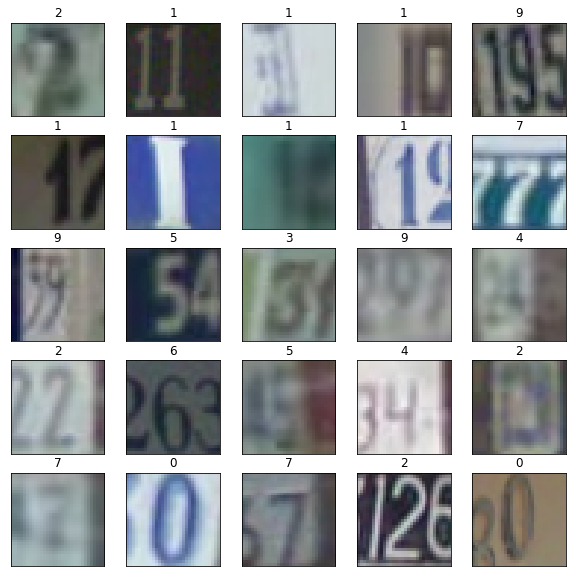

In [0]:
indices = random.sample(range(len(dataset_train)), 25)
fig, ax = plt.subplots(nrows = 5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for ax, image, label in zip(axes, dataset_train.dataset.data[indices], dataset_train.dataset.labels[indices]):
    plt.sca(ax)
    plt.imshow(np.moveaxis(image, 0, 2))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.title(label)

One can see that there are several issues connected with this dataset:

* Blurry images
* Digits other than labeled are present in the image

At least from the brief inspection we can except that out dataset is labeled correctly.

Loading pretrained resnet
#TODO: Describe the network and justify its use

In [0]:
model = resnet18(pretrained=True)
model.eval();

Defining extractor using custom class to extract features from last cnn pretrained layer.

In [0]:
extractor = FeatureExtractor(model=model, n_remove_layers=1, n_features=n_features, device=device)

In [0]:
%%skip $TRAINED

X_train_codes, y_train_codes = extractor.extract_features(dataset_train)
X_valid_codes, y_valid_codes = extractor.extract_features(dataset_valid)
X_test_codes, y_test_codes = extractor.extract_features(dataset_test)

In [0]:
%%skip $TRAINED

torch.save((X_train_codes, y_train_codes), 'train_codes.pt')
torch.save((X_valid_codes, y_valid_codes), 'valid_codes.pt')
torch.save((X_test_codes, y_test_codes), 'test_codes.pt')

In [0]:
X_train_codes, y_train_codes = torch.load('/content/drive/My Drive/train_codes.pt')
X_valid_codes, y_valid_codes = torch.load('/content/drive/My Drive/valid_codes.pt')
X_test_codes, y_test_codes = torch.load('/content/drive/My Drive/test_codes.pt')

Training kNN-classifier on top of cnn codes with cross-validated grid search. We are going to use validation score as an indicator fo best model.

In [0]:
%%skip $TRAINED

params = {'n_neighbors': list(range(5, 30, 5))}
clf = GridSearchValidation(model=KNeighborsClassifier, scorer=mean_average_precision, parameter_grid=params)
clf.fit(X_train_codes, y_train_codes, X_valid_codes, y_valid_codes)

Current train score equals 0.687873702780144
Current validation score equals 0.4463249520513374
Current train score equals 0.6529295918750488
Current validation score equals 0.5042928890291493
Current train score equals 0.6398075813482039
Current validation score equals 0.5281797186300037
Current train score equals 0.6312585842815057
Current validation score equals 0.5398620855587555
Current train score equals 0.6251966011604694
Current validation score equals 0.5476943081453388


GridSearchValidation(model=<class 'sklearn.neighbors.classification.KNeighborsClassifier'>,
                     parameter_grid=[{'n_neighbors': 5}, {'n_neighbors': 10},
                                     {'n_neighbors': 15}, {'n_neighbors': 20},
                                     {'n_neighbors': 25}],
                     scorer=<function mean_average_precision at 0x7f717711b598>)

In [0]:
clf.best_model_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [0]:
%%skip $TRAINED

with open('knn_model.pickle', 'wb') as model_save:
    pickle.dump(clf, model_save)

In [0]:
with open('knn_model.pickle', 'rb') as model_load:
    clf = pickle.load(model_load)

In [0]:
train_predictions = clf.predict_proba(X_train_codes)
test_predictions = clf.predict_proba(X_test_codes)

Calculating mean average precision score on test sample

In [0]:
mean_average_precision(y_test_codes, test_predictions)

0.48903346528043246

# tSNE visualisation

In [0]:
tsne = TSNE()
X_codes_tsne = tsne.fit_transform(X_train_codes)

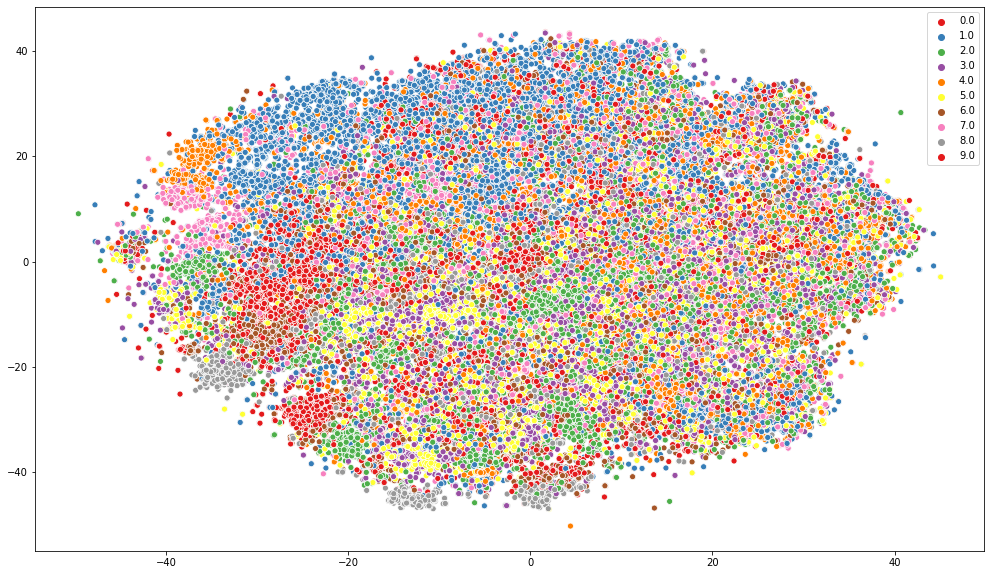

In [0]:
plot_reduction_results(X_codes_tsne, y_train_codes, np.unique(y_train_codes))